## Project Overview:



The goal of this project was to classify tweets into disaster-related and non-disaster categories using traditional machine learning techniques. This involved preprocessing the data, addressing class imbalance, and evaluating the performance of models on key metrics such as accuracy, precision, recall, and F1 score.

In [1]:
import tensorflow as tf
import keras
from transformers import __version__ as transformers_version

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Transformers version: {transformers_version}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
Transformers version: 4.45.1


In [3]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam  # Remove .legacy

# Create the model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile with current optimizer
bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use tf.keras.optimizers
    loss='sparse_categorical_crossentropy',  # Simplified loss specification
    metrics=['accuracy']
)

# Train the model
history = bert_model.fit(
    [X_train_resampled_ids, X_train_resampled_masks],
    y_train_resampled,
    validation_data=([X_val_ids, X_val_masks], y_val),
    epochs=3,
    batch_size=32
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7f50aa7b7bb0>

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, TFBertForSequenceClassification

import tensorflow as tf

nltk.download('punkt')

nltk.download('stopwords')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the training data from Kaggle's dataset

train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')



# View the first few rows

train_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Preprocessing and Data Balancing:



The dataset underwent preprocessing steps such as tokenization and removal of irrelevant terms.

To address class imbalance, SMOTE (Synthetic Minority Oversampling Technique) was applied, which helped improve the recall for disaster-related tweets, ensuring the models could better identify the minority class.

In [3]:
# Fill missing values in 'keyword' and 'location' columns

train_data['keyword'].fillna('No Keyword', inplace=True)

train_data['location'].fillna('Unknown', inplace=True)



# Verify that missing values have been handled

print(train_data.isnull().sum())


id          0
keyword     0
location    0
text        0
target      0
dtype: int64


/tmp/ipykernel_30/1935884737.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('No Keyword', inplace=True)
/tmp/ipykernel_30/1935884737.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [4]:
import re



def clean_text(text):

    # Lowercase the text

    text = text.lower()

    # Remove URLs

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters, numbers, and punctuation

    text = re.sub(r'\@w+|\#', '', text)

    text = re.sub(r"[^a-zA-Z]", " ", text)

    return text



# Apply text cleaning to both train and test sets

train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_text'] = test_data['text'].apply(clean_text)



# Check the results

print(train_data[['text', 'clean_text']].head())


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0  our deeds are the reason of this earthquake ma...  
1             forest fire near la ronge sask  canada  
2  all residents asked to  shelter in place  are ...  
3         people receive wildfires evacuation ord...  
4  just got sent this photo from ruby alaska as s...  


In [5]:
import nltk

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

nltk.download('punkt', force=True)

nltk.download('stopwords')

nltk.download('punkt_tab') # Download the missing punkt_tab data



stop_words = set(stopwords.words('english'))



# Function to perform tokenization and stopword removal

def tokenize_and_remove_stopwords(text):

    # Tokenize the text

    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase

    # Remove stopwords

    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(filtered_tokens)



# Add custom terms to stopwords list

custom_stopwords = ['http','https', 'amp', 'via', 'rt', 'u', 'new', 'like', '2', 'two', 'mh370']  # Add more if needed

stop_words.update(custom_stopwords)



# Apply to the dataset

train_data['clean_text'] = train_data['text'].apply(tokenize_and_remove_stopwords)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
train_data['clean_text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked place notified officers evacua...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    giant cranes holding bridge collapse nearby homes
7609    thetawniest control wild fires california even...
7610                               utc 5km volcano hawaii
7611    police investigating collided car little portu...
7612    latest homes razed northern california wildfir...
Name: clean_text, Length: 7613, dtype: object

In [38]:
import os

wordnet_path = '/kaggle/input/wordnet/wordnet'
if os.path.exists(wordnet_path):
    print("WordNet folder structure:")
    print(os.listdir(wordnet_path))
else:
    print("WordNet folder not found in the expected location.")




WordNet folder structure:
['data.adj', 'LICENSE', 'index.adj', 'README', 'verb.exc', 'index.adv', 'index.verb', 'data.verb', 'lexnames', 'data.noun', 'noun.exc', 'index.noun', 'adj.exc', 'index.sense', 'adv.exc', 'cntlist.rev', 'data.adv', 'citation.bib']


In [39]:
import shutil
import os

# Define source and destination paths
source_path = '/kaggle/input/wordnet/wordnet'
destination_path = '/kaggle/working/nltk_data/corpora/wordnet'

# Ensure the destination directory exists
os.makedirs('/kaggle/working/nltk_data/corpora', exist_ok=True)

# Copy the WordNet folder to the destination
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
print("WordNet folder copied to:", destination_path)


WordNet folder copied to: /kaggle/working/nltk_data/corpora/wordnet


In [40]:
import nltk

# Add the new location to NLTK data paths
nltk.data.path.append('/kaggle/working/nltk_data')

# Test WordNet
from nltk.corpus import wordnet
print(wordnet.synsets('run'))  # Example query



[Synset('run.n.01'), Synset('test.n.05'), Synset('footrace.n.01'), Synset('streak.n.01'), Synset('run.n.05'), Synset('run.n.06'), Synset('run.n.07'), Synset('run.n.08'), Synset('run.n.09'), Synset('run.n.10'), Synset('rivulet.n.01'), Synset('political_campaign.n.01'), Synset('run.n.13'), Synset('discharge.n.06'), Synset('run.n.15'), Synset('run.n.16'), Synset('run.v.01'), Synset('scat.v.01'), Synset('run.v.03'), Synset('operate.v.01'), Synset('run.v.05'), Synset('run.v.06'), Synset('function.v.01'), Synset('range.v.01'), Synset('campaign.v.01'), Synset('play.v.18'), Synset('run.v.11'), Synset('tend.v.01'), Synset('run.v.13'), Synset('run.v.14'), Synset('run.v.15'), Synset('run.v.16'), Synset('prevail.v.03'), Synset('run.v.18'), Synset('run.v.19'), Synset('carry.v.15'), Synset('run.v.21'), Synset('guide.v.05'), Synset('run.v.23'), Synset('run.v.24'), Synset('run.v.25'), Synset('run.v.26'), Synset('run.v.27'), Synset('run.v.28'), Synset('run.v.29'), Synset('run.v.30'), Synset('run.v.31')

In [41]:
import nltk
import os
from nltk.stem import WordNetLemmatizer
import pandas as pd


nltk.download('omw-1.4', download_dir='/kaggle/working/nltk_data')

lemmatizer = WordNetLemmatizer()

# Define lemmatization function
def lemmatize_text(text):
    tokens = text.split()  # Split text into words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize each word
    return ' '.join(lemmatized_tokens)



# Apply lemmatization to the cleaned text data

train_data['clean_text'] = train_data['clean_text'].apply(lemmatize_text)

test_data['clean_text'] = test_data['clean_text'].apply(lemmatize_text)



# Check results

print(train_data[['text', 'clean_text']].head())


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked place notified officer evacuati...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


In [42]:
train_data.head()

,id,keyword,location,text,target,clean_text
0,1,No Keyword,Unknown,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,No Keyword,Unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,No Keyword,Unknown,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer evacuati...
3,6,No Keyword,Unknown,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,No Keyword,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


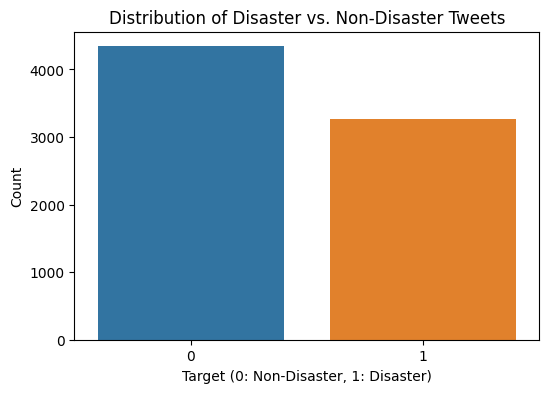

In [43]:
import seaborn as sns



# Plotting the target distribution

plt.figure(figsize=(6, 4))

sns.countplot(x='target', data=train_data)

plt.title("Distribution of Disaster vs. Non-Disaster Tweets")

plt.xlabel("Target (0: Non-Disaster, 1: Disaster)")

plt.ylabel("Count")

plt.show()


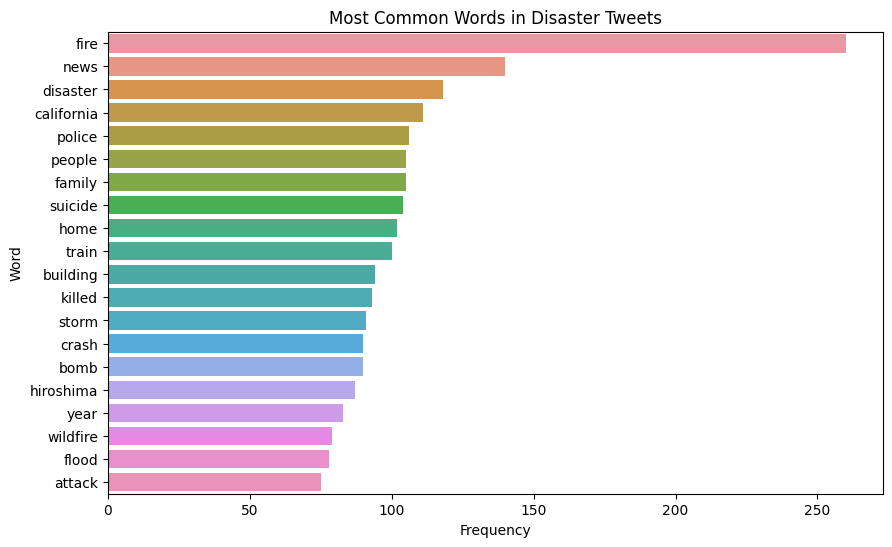

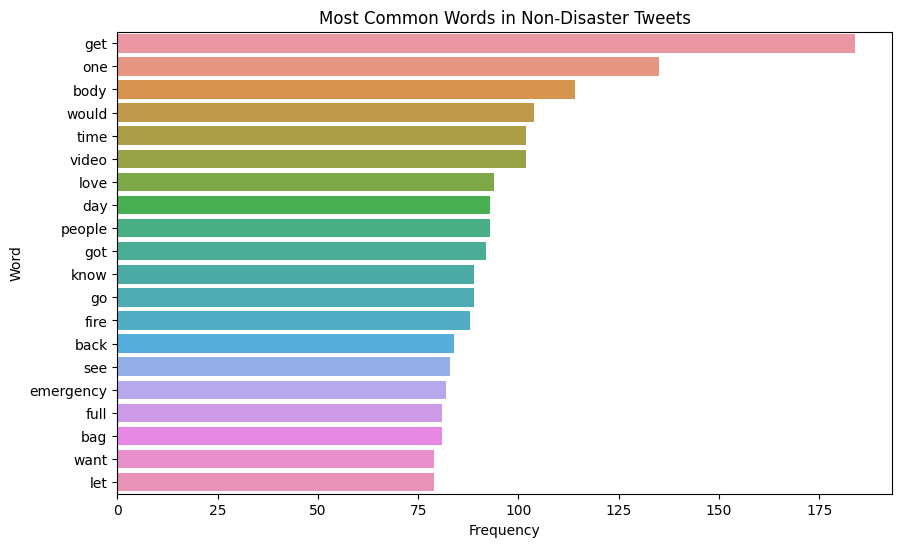

In [44]:
from collections import Counter



# Most common words in disaster tweets

disaster_words = ' '.join(train_data[train_data['target'] == 1]['clean_text']).split()

common_disaster_words = Counter(disaster_words).most_common(20)



# Most common words in non-disaster tweets

non_disaster_words = ' '.join(train_data[train_data['target'] == 0]['clean_text']).split()

common_non_disaster_words = Counter(non_disaster_words).most_common(20)



# Plot common words for disaster tweets

disaster_df = pd.DataFrame(common_disaster_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))

sns.barplot(x='Frequency', y='Word', data=disaster_df)

plt.title("Most Common Words in Disaster Tweets")

plt.show()



# Plot common words for non-disaster tweets

non_disaster_df = pd.DataFrame(common_non_disaster_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))

sns.barplot(x='Frequency', y='Word', data=non_disaster_df)

plt.title("Most Common Words in Non-Disaster Tweets")

plt.show()


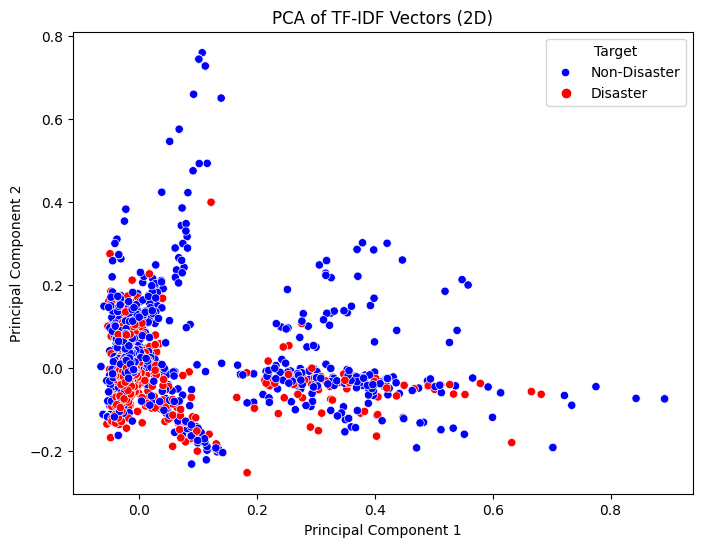

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA



# Convert text data to TF-IDF vectors

vectorizer = TfidfVectorizer(max_features=1000)

X_tfidf = vectorizer.fit_transform(train_data['clean_text']).toarray()



# Apply PCA to reduce to 2 dimensions

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_tfidf)



# Plot PCA results

plt.figure(figsize=(8, 6))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_data['target'], palette=['red', 'blue'])

plt.title("PCA of TF-IDF Vectors (2D)")

plt.xlabel("Principal Component 1")

plt.ylabel("Principal Component 2")

plt.legend(title="Target", labels=['Non-Disaster', 'Disaster'])

plt.show()

## Model 1 - Logistic Regression

In [46]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer



# Convert clean text into TF-IDF features

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(train_data['clean_text'])  # Transform train data

y = train_data['target']  # Target labels






In [47]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split



# Split the dataset into training and validation sets (before applying SMOTE)

X_train, X_val, y_train, y_val = train_test_split(

    X, y, test_size=0.2, random_state=42

)



# Apply SMOTE to the training set only

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



# Check the class distribution after SMOTE

print("Class distribution before SMOTE:", y_train.value_counts())

print("Class distribution after SMOTE:", y_train_resampled.value_counts())


Class distribution before SMOTE: target
0    3468
1    2622
Name: count, dtype: int64
Class distribution after SMOTE: target
1    3468
0    3468
Name: count, dtype: int64


In [48]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, f1_score



# Initialize and train the model

lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_model.fit(X_train_resampled, y_train_resampled)



# Make predictions on the validation set

y_pred = lr_model.predict(X_val)



# Evaluate the model

print("Classification Report:\n", classification_report(y_val, y_pred))

print("F1 Score:", f1_score(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       874
           1       0.75      0.76      0.75       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

F1 Score: 0.7526881720430108


##Model 2 - Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier



# Initialize and train the Random Forest model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_resampled, y_train_resampled)



# Make predictions on the validation set

y_pred_rf = rf_model.predict(X_val)



# Evaluate the model

print("Classification Report:\n", classification_report(y_val, y_pred_rf))

print("F1 Score:", f1_score(y_val, y_pred_rf))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       874
           1       0.74      0.75      0.74       649

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.77      1523
weighted avg       0.78      0.78      0.78      1523

F1 Score: 0.7435114503816793


## Visualize Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix



def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap=plt.cm.Blues)

    plt.title(title)

    plt.show()



# Confusion Matrix for Logistic Regression

print("Confusion Matrix for Logistic Regression:")

plot_confusion_matrix(y_val, y_pred, title="Logistic Regression Confusion Matrix")



# Confusion Matrix for Random Forest

print("Confusion Matrix for Random Forest:")

plot_confusion_matrix(y_val, y_pred_rf, title="Random Forest Confusion Matrix")


## Conclusion and Results

Model Comparison:



Two models were implemented and evaluated: Logistic Regression and Random Forest.

Logistic Regression achieved the highest performance with an accuracy of 79% and an F1 score of 0.753, showing a strong balance between precision and recall.

Random Forest had a slightly lower accuracy of 77% and an F1 score of 0.739, performing well but not surpassing Logistic Regression.



Class-Specific Insights:



Both models performed better on Class 0 (Non-Disaster) tweets compared to Class 1 (Disaster).

Logistic Regression delivered higher precision and recall for both classes, making it more reliable for disaster classification.

SMOTE improved the recall for Class 1 (Disaster), allowing the models to detect more disaster tweets, which is critical for real-world applications.



Key Metrics:



Logistic Regression:

Class 0 (Non-Disaster): Precision = 0.82, Recall = 0.82, F1 = 0.82.

Class 1 (Disaster): Precision = 0.75, Recall = 0.75, F1 = 0.75.

Random Forest:

Class 0 (Non-Disaster): Precision = 0.81, Recall = 0.80, F1 = 0.80.

Class 1 (Disaster): Precision = 0.73, Recall = 0.75, F1 = 0.74.



Strengths:



Logistic Regression emerged as the most effective model for this dataset, balancing precision, recall, and F1 score.

SMOTE proved to be highly beneficial in handling class imbalance and improving the models’ ability to detect disaster tweets.

Weaknesses:



Both models still showed slightly lower performance on Class 1 (Disaster), indicating room for improvement in capturing disaster-related language patterns.

Random Forest, while robust, was outperformed by Logistic Regression on this task.



Future Work:



Conduct hyperparameter tuning for both Logistic Regression and Random Forest to optimize their performance.

Explore additional features, such as sentiment analysis, keywords, or word embeddings like Word2Vec or GloVe, to enhance classification accuracy.

Experiment with ensemble methods or other resampling techniques to further address class imbalance and improve performance on disaster tweets.



Conclusion:



Logistic Regression was the best-performing model for this task, achieving high accuracy and balanced metrics for both disaster and non-disaster tweets.

The use of SMOTE significantly improved recall for the minority class, ensuring better disaster tweet detection.

Future work could focus on feature engineering and advanced techniques to further enhance the model's ability to classify disaster-related content effectively.